In [1]:
import pandas as pd
import numpy as np
from generate_data import generate_data
import matplotlib.pyplot as plt
from discrete_lognormal import DiscreteLognormal
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

In [2]:
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [4]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 6.009662
         Iterations: 8
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 8


In [5]:
gpois_res.params

intercept                   5.204422
days_since_start            0.376055
days_since_start_squared   -0.120497
day_of_week_1               0.276530
day_of_week_2               0.266111
day_of_week_3               0.307868
day_of_week_4               0.292515
day_of_week_5               0.195261
day_of_week_6               0.071607
seasonality_cos             0.133759
seasonality_sin            -0.067028
alpha                       7.018850
dtype: float64

In [6]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.053      
Dependent Variable:    y                   AIC:               13185.1608 
Date:                  2022-04-06 18:06    BIC:               13245.1429 
No. Observations:      1095                Log-Likelihood:    -6580.6    
Df Model:              10                  LL-Null:           -6951.6    
Df Residuals:          1084                LLR p-value:       5.7000e-153
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2044   0.0390 133.2890 0.0000  5.1279  5.2810
days_since_start          0.3761   0.0149  25.2066 0.0000  0.3468  0.4053
days_since_start_squared -0.1205   0.0139  -8.6868 0.0000 -0.

In [8]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [9]:
# np.seterr(divide = 'warn')
# np.seterr(invalid= 'warn')

start_params = np.zeros(22)
start_params[:11] = gpois_res.params[:11]
start_params[11] = -1.
mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
start_params = np.zeros(22)

mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=0.)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.928105
         Iterations: 39
         Function evaluations: 46
         Gradient evaluations: 46
                          DiscreteLognormal Results                           
Dep. Variable:                      y   Log-Likelihood:                -6491.3
Model:              DiscreteLognormal   AIC:                         1.300e+04
Method:            Maximum Likelihood   BIC:                         1.306e+04
Date:                Wed, 06 Apr 2022                                         
Time:                        18:06:13                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------

In [11]:
# Test first-order EM
mod_em_first = mod.fit(
    start_params=start_params,
    method="EM", 
    use_hessian=False,
    maxiter=1000,
    step_size=1e-3,
    tol=1e-6,
    penalty=1e-4)

/Users/mferlic/Dropbox (University of Michigan)/course work/Stats 606 - Comp Opt Methods/project/discrete-lognormal-mle/discrete_lognormal.py:11: RuntimeWarning: divide by zero encountered in log
  ll = stats.norm.logcdf(z_underbar) + np.log(np.exp(stats.norm.logcdf(z_bar) - stats.norm.logcdf(z_underbar)) - 1.)


In [12]:
# Test second-order EM
start_params[11] = -0.5
mod_em_second = mod.fit(
    start_params=start_params,
    method="EM",
    use_hessian=True,
    maxiter=100,
    tol=1e-6,
    penalty=1e-4)
# Sensitive to good starting values

/Users/mferlic/Dropbox (University of Michigan)/course work/Stats 606 - Comp Opt Methods/project/discrete-lognormal-mle/discrete_lognormal.py:193: RuntimeWarning: invalid value encountered in multiply
  2*self.mu*self.sigma*kappa_0
/Users/mferlic/Dropbox (University of Michigan)/course work/Stats 606 - Comp Opt Methods/project/discrete-lognormal-mle/discrete_lognormal.py:219: RuntimeWarning: invalid value encountered in matmul
  XtSie1 = X.T @ (self.sigma**-2 * self.e1)
/Users/mferlic/Dropbox (University of Michigan)/course work/Stats 606 - Comp Opt Methods/project/discrete-lognormal-mle/discrete_lognormal.py:223: RuntimeWarning: invalid value encountered in multiply
  c = self.e2 - 2*self.e1*self.mu + self.mu**2 # NOTE: This is using the updated mu


RuntimeError: Hit maxiter and failed to converge

In [13]:
def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(yhat, y):
    r = y - yhat
    return np.mean(r**2)

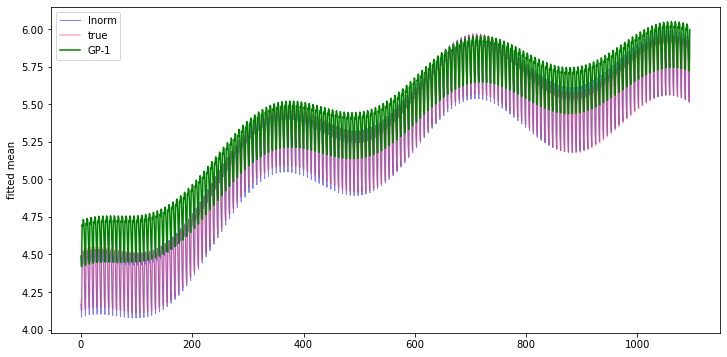

In [14]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.plot(gpois_res.fittedvalues, color ="green", label = "GP-1")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

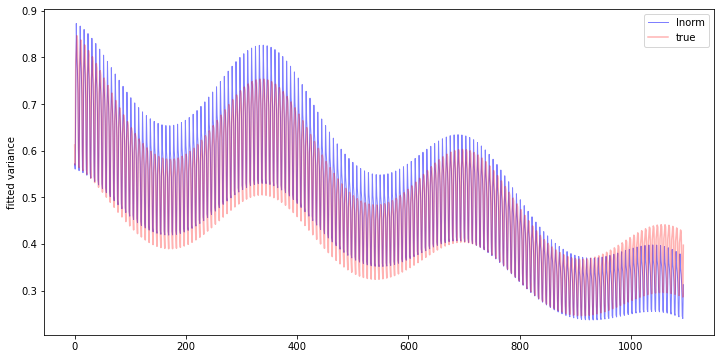

In [15]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

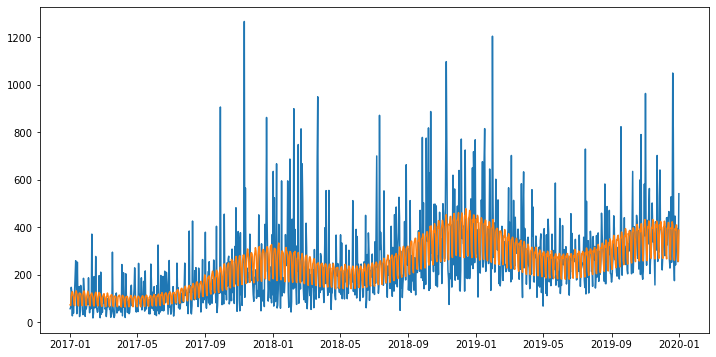

In [16]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

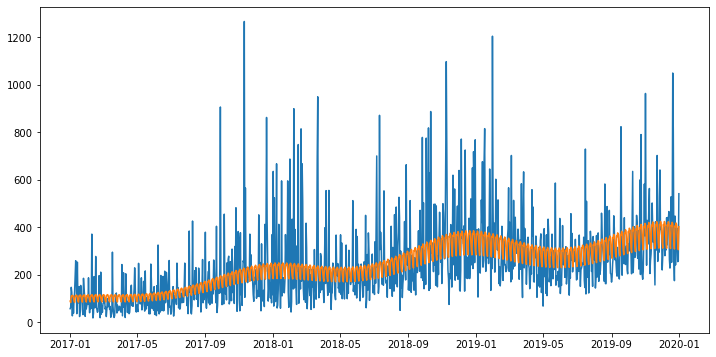

In [17]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

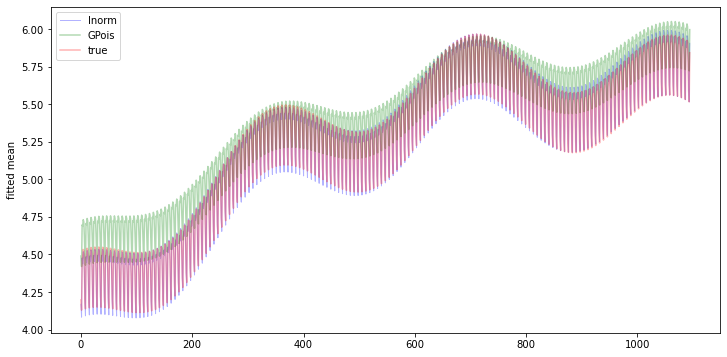

In [18]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [ ]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

In [ ]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     bs = mod_res.bootstrap(nrep=1, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [ ]:
# bs[0] #mean estimates

## Simulation - comparing MSPE using different models

In [24]:

N = 100
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        #print(i)
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["POI"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["GP1"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["DLN"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        data = generate_data() #new data
        Xnew = data.x_df
        # out of sample prediction MSE
        sim_mse.append([mse(mod_res.predict(exog=Xnew), data.y), mse(pois_res.predict(exog=Xnew), data.y), 
                        mse(gpois_res.predict(exog=Xnew), data.y), mse(NB1_res.predict(exog=Xnew), data.y)])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [25]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [36]:
sim_params.groupby(by = "model").agg(["mean", "std"]).T

model                               DLN       GP1       NB1       POI
intercept                mean  5.007696  5.229247  5.184834  5.084127
                         std   0.030281  0.030472  0.031085  0.034808
days_since_start         mean  0.400511  0.353241  0.345296  0.350124
                         std   0.015333  0.013835  0.015125  0.020999
days_since_start_squared mean -0.172849 -0.133422 -0.144299 -0.175766
                         std   0.013620  0.011971  0.012580  0.016153
day_of_week_1            mean  0.325486  0.237382  0.287897  0.390186
                         std   0.046297  0.040394  0.042876  0.055320
day_of_week_2            mean  0.354274  0.252446  0.308932  0.422336
                         std   0.053598  0.048877  0.050897  0.063913
day_of_week_3            mean  0.394312  0.283153  0.349016  0.481104
                         std   0.053998  0.047122  0.049797  0.062990
day_of_week_4            mean  0.376809  0.269679  0.333237  0.458877
                         std   0.049717  0.048059  0.049643  0.059898
day_of_week_5            mean  0.247865  0.181562  0.217716  0.292022
                         std   0.053000  0.047821  0.050424  0.061378
day_of_week_6            mean  0.063026  0.047723  0.055154  0.071898
                         std   0.041505  0.036037  0.038279  0.047125
seasonality_cos          mean  0.202745  0.149158  0.180000  0.239622
                         std   0.018480  0.017747  0.018617  0.024056
seasonality_sin          mean -0.097726 -0.072449 -0.083618 -0.108898
                         std   0.020697  0.019629  0.020470  0.025845

In [33]:
# OOS MSE
print(pd.DataFrame(sim_mse, columns=["DLN", "POI", "GP1", "NB1"]).agg(["mean", "std"]).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &           DLN &           POI &           GP1 &           NB1 \\
\midrule
mean &  20628.715443 &  20677.349160 &  21258.058928 &  20892.076206 \\
std  &   3021.524422 &   3030.379111 &   3157.533030 &   3115.621102 \\
\bottomrule
\end{tabular}

